# Homework 9

The goal of this HW is simple. Duplicate (repeat all parts of) homework 8 problem 2 using neural networks. Perform an appropriate contrast of your regression results versus using 

i.) a neural network with 2 hidden nodes and 

ii.) 4 hidden nodes over 2 layers with 2 hidden nodes in each layer. 

All layers should be full connectected, MSE the loss function, a linear output activation layer and RELUs otherwise.

You should return an ipynb nothebook with your code and a final table contrasting the different error rates of the different approaches you tried.

In [1]:
import pandas as pd
import numpy as np
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO

## Read in the data and display rows
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))
df.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
5,NaN,Antarctica,-71.94990,23.347000,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
6,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,9106,9106,9106,9106,9106,9106,9106,9106,9106,9106
7,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,10044125,10044125,10044125,10044125,10044125,10044125,10044957,10044957,10044957,10044957
8,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,446819,446819,446819,446819,446819,446819,446819,446819,447308,447308
9,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,232018,232018,232619,232619,232619,232619,232619,232619,232619,232974


Consider US as country A and clean the dataset

In [2]:
# Choose a country ('US')
country = 'US'
df_country = df[df['Country/Region'] == country]

df_country = df_country.drop(columns=['Lat', 'Long'])

# Sum cases across different provinces/states for the US
df_country = df_country.sum(numeric_only=True, axis=0)

# Convert the series to a DataFrame and reset the index
df_country = pd.DataFrame(df_country).reset_index()
df_country.columns = ['Date', 'Cases']

me =df_country['Cases'].mean()
sd = df_country['Cases'].std()
df_country['std_Cases'] = (df_country['Cases'] - me)/sd

In [3]:
# Convert from Cumulative to Daily Cases
covid_data_daily = df_country['std_Cases'].diff()
df_country['Daily'] = covid_data_daily

# Reset the index to represent days since the outbreak onset (t=0)
df_country = df_country.reset_index(drop=True)

# Create lagged variables (up to 5 days) -- note the lagged case variables refer to daily case counts
for i in range(1, 6):
    df_country[f'Cases_lag{i}'] = df_country['Daily'].shift(i)

# Drop rows with NaN values caused by lagging
df_country = df_country.dropna()
df_country.head()

# Define dependent and independent variables
y = df_country['Daily']
X = df_country[['Cases_lag1', 'Cases_lag2', 'Cases_lag3', 'Cases_lag4', 'Cases_lag5']]

In [4]:
print(df_country.columns)
print(df_country.head(2))

Index(['Date', 'Cases', 'std_Cases', 'Daily', 'Cases_lag1', 'Cases_lag2',
       'Cases_lag3', 'Cases_lag4', 'Cases_lag5'],
      dtype='object')
      Date  Cases  std_Cases         Daily  Cases_lag1    Cases_lag2  \
6  1/28/20      5  -1.290768  0.000000e+00         0.0  8.224834e-08   
7  1/29/20      6  -1.290768  2.741611e-08         0.0  0.000000e+00   

     Cases_lag3    Cases_lag4    Cases_lag5  
6  0.000000e+00  2.741611e-08  0.000000e+00  
7  8.224834e-08  0.000000e+00  2.741611e-08  


In [5]:
print(X.head())

      Cases_lag1    Cases_lag2    Cases_lag3    Cases_lag4    Cases_lag5
6   0.000000e+00  8.224834e-08  0.000000e+00  2.741611e-08  0.000000e+00
7   0.000000e+00  0.000000e+00  8.224834e-08  0.000000e+00  2.741611e-08
8   2.741611e-08  0.000000e+00  0.000000e+00  8.224834e-08  0.000000e+00
9   0.000000e+00  2.741611e-08  0.000000e+00  0.000000e+00  8.224834e-08
10  5.483223e-08  0.000000e+00  2.741611e-08  0.000000e+00  0.000000e+00


First, consider the whole dataset

In [6]:
n = len(df_country)
# change DF to numpy.array and then to tensor
std_y = torch.from_numpy(df_country['Daily'].astype(float).to_numpy())
std_X = torch.from_numpy(df_country.iloc[:,4:].astype(float).to_numpy())

# change to float
std_y = std_y.float()
std_X = std_X.float()

# change the shape of Y from [1137]-->[1137,1]
std_y = std_y.unsqueeze(1)

print(f"std_y shape: {std_y.shape}")
print(f"std_X shape: {std_X.shape}")
print(f"n: {n}")

std_y shape: torch.Size([1137, 1])
std_X shape: torch.Size([1137, 5])
n: 1137


In [7]:
np.random.seed(3468)
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)
print(model)
print("displaying parameters ",
      list(model.parameters()))  # why it has output already? is this randomly assigned? not sure about the number of parameters

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred = model(std_X)

    # the loss for this itneration
    loss = loss_fn(y_pred, std_y)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    # Zero out the gradient 
    optimizer.zero_grad()

    # Backprop
    loss.backward()

  # Optimization step
    optimizer.step()

# present the final parameters
for param in model.parameters():
    print(param)

Sequential(
  (0): Linear(in_features=5, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
displaying parameters  [Parameter containing:
tensor([[-0.3287, -0.3143,  0.3492,  0.2263,  0.0796],
        [ 0.1121, -0.1358, -0.2354,  0.2737,  0.0621]], requires_grad=True), Parameter containing:
tensor([0.2114, 0.2020], requires_grad=True), Parameter containing:
tensor([[-0.1394,  0.5167]], requires_grad=True), Parameter containing:
tensor([0.1433], requires_grad=True)]
999 tensor(3.8672, grad_fn=<MseLossBackward0>)
1999 tensor(0.0455, grad_fn=<MseLossBackward0>)
2999 tensor(0.0203, grad_fn=<MseLossBackward0>)
3999 tensor(0.0187, grad_fn=<MseLossBackward0>)
4999 tensor(0.0164, grad_fn=<MseLossBackward0>)
5999 tensor(0.0135, grad_fn=<MseLossBackward0>)
6999 tensor(0.0104, grad_fn=<MseLossBackward0>)
7999 tensor(0.0076, grad_fn=<MseLossBackward0>)
8999 tensor(0.0055, grad_fn=<MseLossBackward0>)
9999 tensor(0.0043, grad_fn=<MseLossBackward0>)
Par

In [8]:
std_y_pred = model(std_X)
std_y_pred = y_pred.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y = std_y.numpy().reshape(-1)
# Compute residuals
std_res_full = std_y - std_y_pred

In [9]:
# change DF to numpy.array and then to tensor
std_y2 = torch.from_numpy(df_country['Daily'].astype(float).to_numpy())
std_X2 = torch.from_numpy(df_country.iloc[:,4:].astype(float).to_numpy())

# change to float
std_y2 = std_y2.float()
std_X2 = std_X2.float()

# change the shape of Y from [1137]-->[1137,1]
std_y2 = std_y2.unsqueeze(1)

print(f"std_y2 shape: {std_y2.shape}")
print(f"std_X2 shape: {std_X2.shape}")
print(f"n: {n}")

std_y2 shape: torch.Size([1137, 1])
std_X2 shape: torch.Size([1137, 5])
n: 1137


In [11]:
np.random.seed(6856)
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 2),  # 2 nodes to 2 nodes  ??
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

print("displaying parameters ",
      list(model.parameters())) 

#loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred2 = model(std_X2)

    # the loss for this itneration
    loss = loss_fn(y_pred2, std_y2)
    if t % 1000 == 999:
        print(t, loss)  

    ## Zero out the gradient before adding them up [before we do the back propagation step]
    ## when we accumulate with a back propagation step, it does not add to the previous value.
    optimizer.zero_grad()

    ## Backprop
    loss.backward()

  ## Optimization step
    optimizer.step()


for param in model.parameters():
    print(param)


displaying parameters  [Parameter containing:
tensor([[ 0.3124, -0.1419,  0.0220, -0.2478, -0.3784],
        [-0.1271,  0.1790,  0.0933, -0.1000,  0.4184]], requires_grad=True), Parameter containing:
tensor([-0.3318, -0.4259], requires_grad=True), Parameter containing:
tensor([[ 0.3422,  0.1144],
        [-0.3155,  0.6634]], requires_grad=True), Parameter containing:
tensor([-0.6103,  0.5908], requires_grad=True), Parameter containing:
tensor([[-0.4671,  0.0645]], requires_grad=True), Parameter containing:
tensor([0.1412], requires_grad=True)]
999 tensor(3.4869, grad_fn=<MseLossBackward0>)
1999 tensor(0.0648, grad_fn=<MseLossBackward0>)
2999 tensor(0.0137, grad_fn=<MseLossBackward0>)
3999 tensor(0.0137, grad_fn=<MseLossBackward0>)
4999 tensor(0.0137, grad_fn=<MseLossBackward0>)
5999 tensor(0.0137, grad_fn=<MseLossBackward0>)
6999 tensor(0.0137, grad_fn=<MseLossBackward0>)
7999 tensor(0.0137, grad_fn=<MseLossBackward0>)
8999 tensor(0.0137, grad_fn=<MseLossBackward0>)
9999 tensor(0.0137,

In [12]:
std_y_pred2 = model(std_X2)
std_y_pred2 = y_pred2.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y2 = std_y2.numpy().reshape(-1)
# Compute residuals
std_res_full2 = std_y2 - std_y_pred2

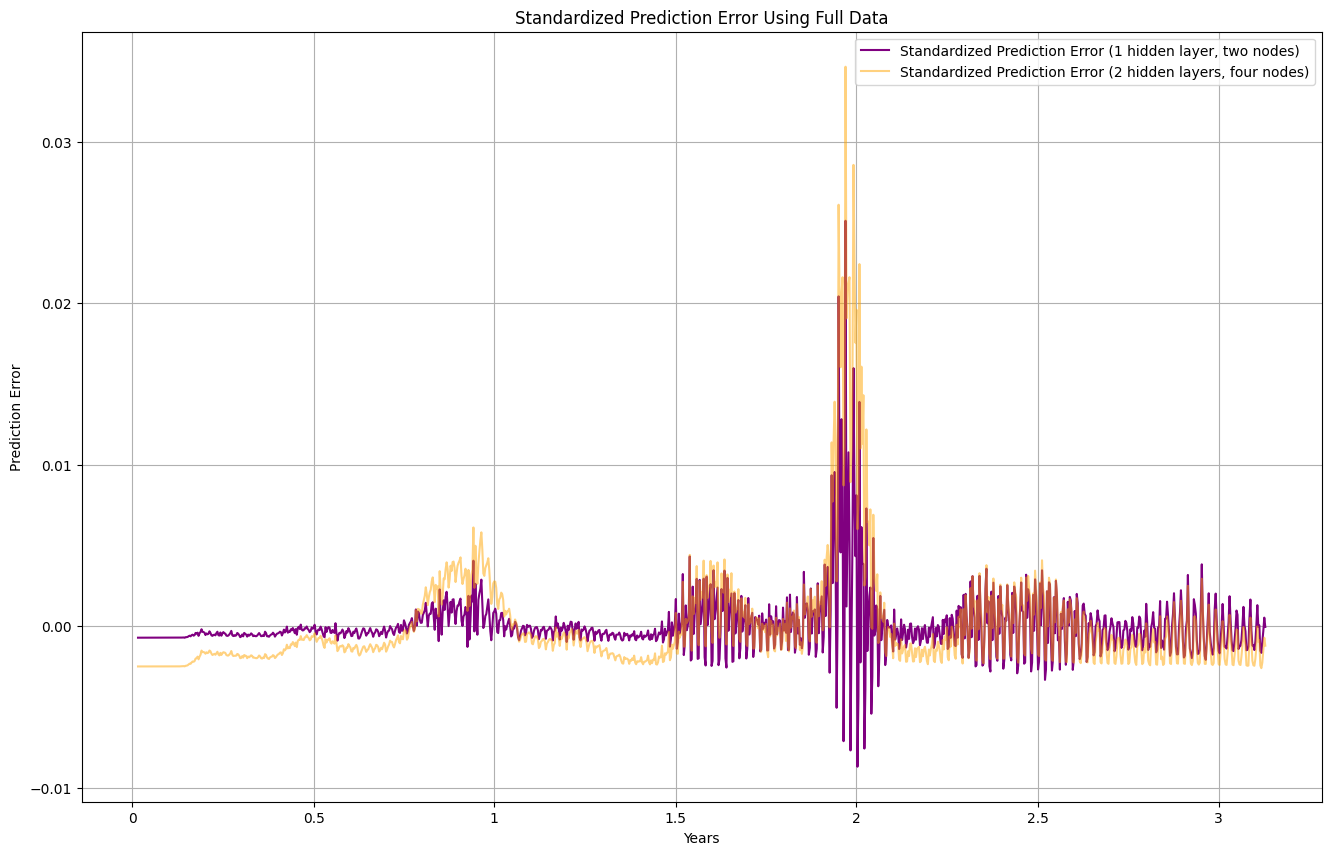

In [13]:
# Create two subplots 1) 1 hidden layer, two nodes 2) 2 hidden layers, four nodes
plt.figure(figsize=(16, 10))
plt.plot(X.index,std_res_full, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
plt.plot(X.index,std_res_full2, label='Standardized Prediction Error (2 hidden layers, four nodes)',color='Orange', alpha=0.5)
plt.xlabel('Years')
plt.xticks([0,183,365,548,730,913,1095],[0,0.5,1,1.5,2,2.5,3])
plt.ylabel('Prediction Error')
plt.title('Standardized Prediction Error Using Full Data')
plt.legend()
plt.grid(True)
plt.show();

Use half as training and half as validation

In [14]:
half_n = len(df_country) // 2
# change DF to numpy.array and then to tensor
std_y_train_half = torch.from_numpy(df_country.iloc[:half_n,3].astype(float).to_numpy())
std_X_train_half = torch.from_numpy(df_country.iloc[:half_n,4:].astype(float).to_numpy())

std_y_test_half = torch.from_numpy(df_country.iloc[half_n:,3].astype(float).to_numpy())
std_X_test_half = torch.from_numpy(df_country.iloc[half_n:,4:].astype(float).to_numpy())

# Change to Float
std_y_train_half = std_y_train_half.float()
std_X_train_half = std_X_train_half.float()

std_y_test_half = std_y_test_half.float()
std_X_test_half = std_X_test_half.float()

# change the shape of Y from [1137]-->[1137,1]
std_y_train_half = std_y_train_half.unsqueeze(1)

In [15]:
np.random.seed(1234)
# Build a neural network model with two hidden nodes
model_half = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.Adam(model_half.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred = model_half(std_X_train_half)

    # the loss for this itneration
    loss = loss_fn(y_pred, std_y_train_half)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    # Zero out the gradient 
    optimizer.zero_grad()

    # Backprop
    loss.backward()

  # Optimization step
    optimizer.step()

# present the final parameters
for param in model_half.parameters():
    print(param)

999 tensor(6.3631, grad_fn=<MseLossBackward0>)
1999 tensor(0.3051, grad_fn=<MseLossBackward0>)
2999 tensor(0.0013, grad_fn=<MseLossBackward0>)
3999 tensor(0.0003, grad_fn=<MseLossBackward0>)
4999 tensor(0.0003, grad_fn=<MseLossBackward0>)
5999 tensor(0.0003, grad_fn=<MseLossBackward0>)
6999 tensor(0.0003, grad_fn=<MseLossBackward0>)
7999 tensor(0.0003, grad_fn=<MseLossBackward0>)
8999 tensor(0.0003, grad_fn=<MseLossBackward0>)
9999 tensor(0.0002, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[ 0.1994, -0.3558, -0.3046, -0.0688, -0.2451],
        [ 0.4090,  0.3093,  0.1563,  0.2951,  0.3428]], requires_grad=True)
Parameter containing:
tensor([-0.1949,  0.1927], requires_grad=True)
Parameter containing:
tensor([[-0.1555,  0.5476]], requires_grad=True)
Parameter containing:
tensor([-0.1052], requires_grad=True)


In [16]:
# Calculate MSE
std_y_test_half_pred = model_half(std_X_test_half)
std_y_test_half_pred = std_y_test_half_pred.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y_test_half_pred = std_y_test_half_pred.reshape(-1)
# Compute residuals
std_res_half = std_y_test_half - std_y_test_half_pred 

In [17]:
# Build a neural network model with two layers, two hidden nodes each
model_half2 = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.Adam(model_half2.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred = model_half2(std_X_train_half)

    # the loss for this itneration
    loss = loss_fn(y_pred, std_y_train_half)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    # Zero out the gradient 
    optimizer.zero_grad()

    # Backprop
    loss.backward()

  # Optimization step
    optimizer.step()

# present the final parameters
for param in model_half2.parameters():
    print(param)

999 tensor(0.5811, grad_fn=<MseLossBackward0>)
1999 tensor(0.0044, grad_fn=<MseLossBackward0>)
2999 tensor(0.0018, grad_fn=<MseLossBackward0>)
3999 tensor(0.0018, grad_fn=<MseLossBackward0>)
4999 tensor(0.0018, grad_fn=<MseLossBackward0>)
5999 tensor(0.0018, grad_fn=<MseLossBackward0>)
6999 tensor(0.0018, grad_fn=<MseLossBackward0>)
7999 tensor(0.0018, grad_fn=<MseLossBackward0>)
8999 tensor(0.0018, grad_fn=<MseLossBackward0>)
9999 tensor(0.0018, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[ 0.0023,  0.1171, -0.3083,  0.2633,  0.3328],
        [ 0.4432, -0.3766,  0.3133, -0.3156, -0.2208]], requires_grad=True)
Parameter containing:
tensor([-0.1117, -0.1950], requires_grad=True)
Parameter containing:
tensor([[ 0.1851,  0.1120],
        [-0.0663,  0.4415]], requires_grad=True)
Parameter containing:
tensor([-0.3235,  0.4370], requires_grad=True)
Parameter containing:
tensor([[-0.2541,  0.0501]], requires_grad=True)
Parameter containing:
tensor([-0.0201], requires_grad=True)


In [18]:
# Calculate MSE
std_y_test_half_pred2 = model_half2(std_X_test_half)
std_y_test_half_pred2 = std_y_test_half_pred2.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y_test_half_pred2 = std_y_test_half_pred2.reshape(-1)
# Compute residuals
std_res_half2 = std_y_test_half - std_y_test_half_pred2 

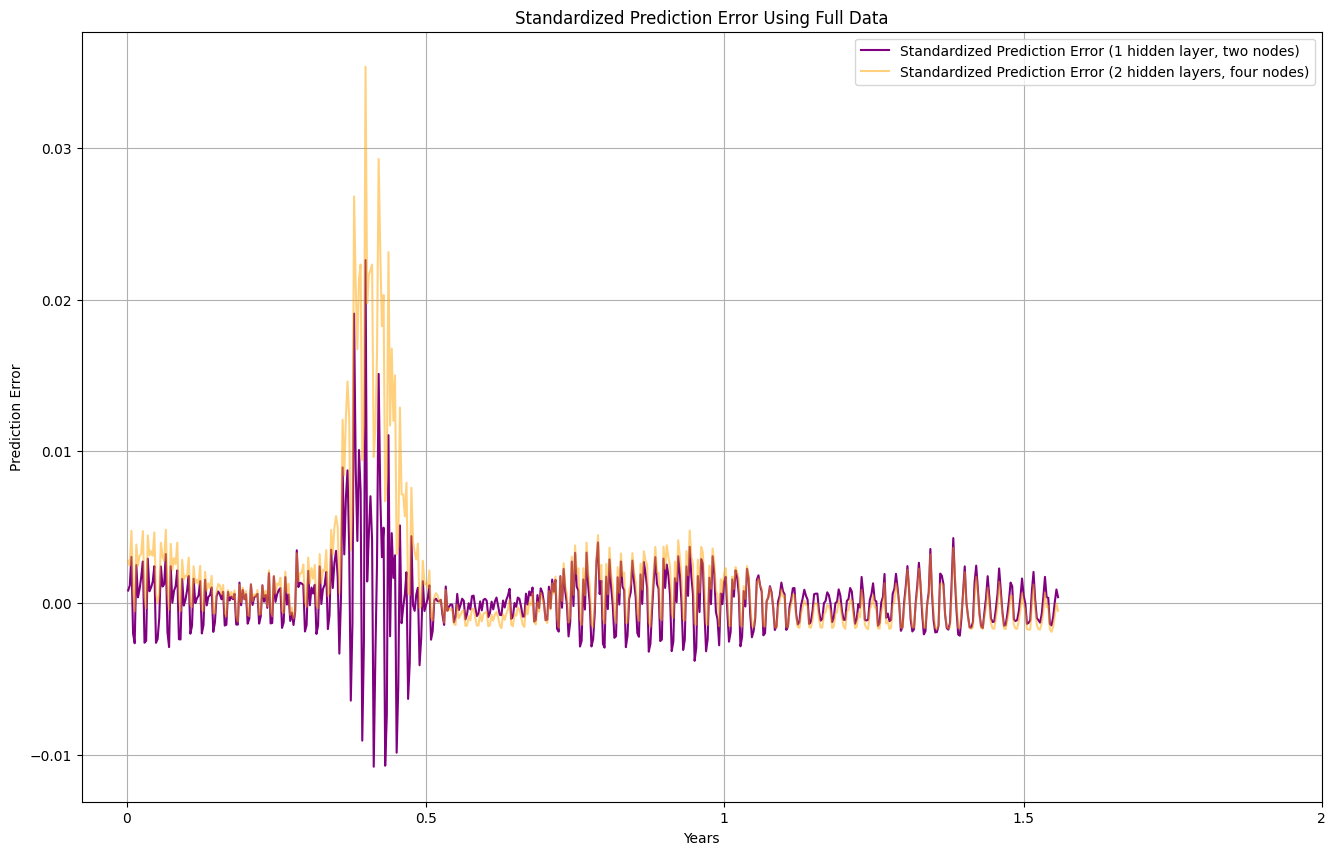

In [19]:
# Plot
X_half = X.iloc[:half_n,]

plt.figure(figsize=(16, 10))
plt.plot(np.arange(1, 570),std_res_half, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
plt.plot(np.arange(1, 570),std_res_half2, label='Standardized Prediction Error (2 hidden layers, four nodes)',color='Orange', alpha=0.5)
plt.xlabel('Years')
plt.xticks([0,183,365,548,730],[0,0.5,1,1.5,2])
plt.ylabel('Prediction Error')
plt.title('Standardized Prediction Error Using Full Data')
plt.legend()
plt.grid(True)
plt.show();